# <font color='red'>-----------------------------------------------------------------------------------------------------</font>
# <font color='green'>Sentiment Labelled Sentences Data Set  - Text classification</font>
## <font color='green'>Text Classification With Python and Keras (different model implementations)</font>
# <font color='red'>-----------------------------------------------------------------------------------------------------</font>

# <ins><div class="alert alert-block alert-info">*Objective: -*</div></ins>

### Customer Sentiment analysis from text reviews with the help of NLP (NLTK and Word2vec and modelling using Convolution neural network

## <ins><div class="alert alert-block alert-info">*Part 1: Extracting the dataset*</div></ins>

### <ins><div class="alert alert-block alert-warning">*Step 1: Reading the text file to create a dataframe*</div></ins>

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# reading the files from the data source and creating dataframe with sentence, label, source
text_dict = {'yelp':r'C:\Users\Indranil\sentiment labelled sentences\sentiment labelled sentences\yelp_labelled.txt',
            'imdb':r'C:\Users\Indranil\sentiment labelled sentences\sentiment labelled sentences\imdb_labelled.txt',
            'amazon':r'C:\Users\Indranil\sentiment labelled sentences\sentiment labelled sentences\amazon_cells_labelled.txt'}

reviews_list = []
for source, filepath in text_dict.items():
    reviews = pd.read_csv(filepath, names=['sentence', 'liked'], sep='\t')
    reviews['source'] = source  # Adding column for the source name
    reviews_list.append(reviews)

reviews = pd.concat(reviews_list)

In [3]:
reviews.shape

(2748, 3)

In [4]:
reviews.head()

,sentence,liked,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp


Our dataframe is built with the statements written as reviews, the ratings 'liked' and the source or the platform where the review was provided

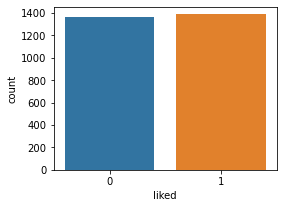

In [5]:
plt.figure(figsize=(4,3))
sns.countplot(reviews['liked'])
plt.show()

#### We seem to have a pretty balanced data set in terms of -ve and +ve sentiments

In [6]:
# resetting index since dataframe is made with 3 sources and index is getting reset after end of items of the previous source
reviews.reset_index(drop=True,inplace=True)

In [7]:
# dropping specific rows since during the pre processing those rows got converted to empty string
reviews.drop(reviews.index[[140,1064,1590]],inplace=True)

In [8]:
reviews.shape

(2745, 3)

### <ins><div class="alert alert-block alert-warning">*Step 2:Text pre-processing*</div></ins>

Text preprocessing steps to remove unwanted elemenmts like emails, special char etc

In [9]:
# importing libraries for text pre processing
import re 
import nltk

nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wrd_lemma = WordNetLemmatizer()

all_stpwrds = stopwords.words('english')
all_stpwrds.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Indranil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Indranil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
#cleaning the data
corpus = []
for i in reviews['sentence']:
      
    cleaned = re.sub('[^a-zA-Z]',' ',i)
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [wrd_lemma.lemmatize(word) for word in cleaned if not word in set(all_stpwrds)]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned) 

Looks like we have a cleaned dataset with preprocessed texts of the reviews

In [11]:
# corpus

### <ins><div class="alert alert-block alert-warning">*Step 3: Processing the corpus for model building and word embedding*</div></ins>

In [12]:
# defining X and y dataset
X = corpus
y = reviews['liked']

# splitting the data into test and training data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [13]:
# importing libraries for deep learning models
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
# # creating a tokenizer
tokenizer = Tokenizer()

In [15]:
# building the word index
tokenizer.fit_on_texts(X_train)

In [16]:
# converting strings into list of integer indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
# displaying word vocabulary
word_vocab = len(tokenizer.word_index)+1
# print(tokenizer.word_index)
# print("Found %s unique words" % word_vocab)

In [18]:
# # padding the sequences for having equal length of input to the model

# finding the largest review sentence
max_len=[]
for i in X_train:
    i = i.split()
    max_len.append(len(i))

max_length = max(max_len)
print(max_length)

404


The largest sequence in the list is 684. We shall use that as max length

In [19]:
X_train_pad = pad_sequences(X_train_seq,maxlen=max_length,padding='post')
X_test_pad = pad_sequences(X_test_seq,maxlen=max_length,padding='post')
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
# print("Shape of the pad_data Tensor",X_test_pad.shape)
# print("Shape of the label Tensor",y_test.shape)

### <ins><div class="alert alert-block alert-warning">*Step 4:Data transformation: Transform the cleaned dataset into vector of words using word embeddings*</div></ins>

In [20]:
# loading word2vec word embeddings
import gensim
wordembeddings = gensim.models.KeyedVectors.load_word2vec_format('D:/GoogleNews-vectors-negative300.bin',binary=True)

In [21]:
tot_words = word_vocab
embed_dim = 300
embed_matrix = np.zeros((tot_words,embed_dim))
skipped_words = []
embed_vect = np.empty(shape=(300,))

for words,index in tokenizer.word_index.items():
    ######## word embedings dont have OOV word and hence will throw error
    if words in wordembeddings:
        embed_vect = wordembeddings[words]
    else:
        skipped_words.append(words)
        
    embed_matrix[index] = embed_vect        

### <ins><div class="alert alert-block alert-warning">*Step 5:Model building: Fitting Deep learning model, model testing*</div></ins>

In [22]:
# create the embedding layer
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
embed_layr = Embedding(tot_words,embed_dim,weights=[embed_matrix],input_length=max_length,trainable=False)

In [23]:
# building the model
model = Sequential()

# building the convolution layers
model.add(embed_layr)
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=512, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# building the dense layers
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 404, 300)          1068900   
                                                                 
 conv1d (Conv1D)             (None, 403, 64)           38464     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 201, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 200, 128)          16512     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 100, 128)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 99, 256)           6

**Training the model**

In [24]:
from keras.optimizers import *

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit network
model.fit(X_train_pad, y_train, batch_size=64,epochs=9, verbose=2)

Epoch 1/9
31/31 - 7s - loss: 0.6924 - accuracy: 0.4971 - 7s/epoch - 216ms/step
Epoch 2/9
31/31 - 5s - loss: 0.5953 - accuracy: 0.6726 - 5s/epoch - 171ms/step
Epoch 3/9
31/31 - 5s - loss: 0.4754 - accuracy: 0.8022 - 5s/epoch - 172ms/step
Epoch 4/9
31/31 - 6s - loss: 0.3669 - accuracy: 0.8532 - 6s/epoch - 180ms/step
Epoch 5/9
31/31 - 6s - loss: 0.3007 - accuracy: 0.8954 - 6s/epoch - 196ms/step
Epoch 6/9
31/31 - 6s - loss: 0.2032 - accuracy: 0.9386 - 6s/epoch - 182ms/step
Epoch 7/9
31/31 - 6s - loss: 0.1496 - accuracy: 0.9531 - 6s/epoch - 187ms/step
Epoch 8/9
31/31 - 6s - loss: 0.1295 - accuracy: 0.9573 - 6s/epoch - 196ms/step
Epoch 9/9
31/31 - 7s - loss: 0.0799 - accuracy: 0.9792 - 7s/epoch - 225ms/step


In [25]:
# evaluate
loss, acc = model.evaluate(X_test_pad, y_test, verbose=2)
print('Test Accuracy: %f' % (acc*100))

26/26 - 1s - loss: 0.6114 - accuracy: 0.8143 - 1s/epoch - 45ms/step
Test Accuracy: 81.432039


**Training accuracy is at ~90% plus and Test accuracy is at ~82% plus. Our model has worked appropriately**<br>
**Let's test our model by giving some reviews as example**

In [26]:
# inp = str(input("Enter review to find sentiment: "))
# a = [inp]
# a_seq = tokenizer.texts_to_sequences(a)
# a_pad = pad_sequences(a_seq,maxlen=max_length,padding='post')
# predict = model.predict(a_pad)
# print(predict)
# if predict > 0.5:
#     print(a,'\n')
#     print("Positive sentiment")
# else:
#     print('Negative sentiment')